# **CIS 5450 Final Project - Predicting Song Popularity & Discovering Musical Structure**

By *Amogh Channashetti, Binoy Patel, & Yohan Vergis Vinu*

# Part 1: Introduction

Music streaming platforms like Spotify generate large-scale audio and metadata signals that capture the structure, style, and popularity of modern music. In this project, we analyze a dataset of over 113,000 Spotify tracks to understand the factors associated with song popularity and to uncover latent musical patterns independent of genre labels. Our work combines supervised learning (predicting whether a song becomes a “hit”) with unsupervised approaches that reveal natural stylistic clusters derived purely from audio features such as energy, acousticness, danceability, loudness, and tempo. Through detailed data cleaning, exploratory analysis, clustering, and baseline modeling, we aim to quantify how musical attributes relate to streaming success and to map out the underlying structure of contemporary music at scale.

# Part 2: Data Loading & Preprocessing

We begin by loading our libraries and the dataset. The dataset is stored in Google Drive for easy access.

## Step 1: Data Loading

**Observations:**
- Google Drive is mounted to access the dataset stored remotely
- The `dataset.csv` file contains over 114,000 Spotify tracks with audio features and metadata
- The file is successfully loaded into a pandas DataFrame for analysis

**Rationale:**
- The initial step of any data analysis pipeline requires accessing and loading the raw data
- Using Google Drive enables collaborative access and version control of the dataset
- Loading into a pandas DataFrame provides a flexible structure for data manipulation and analysis

**What This Achieves:**
- Establishes the foundation for all subsequent preprocessing and analysis steps
- Makes the raw dataset available in memory for exploration and transformation

In [1]:
# Install required packages (run once per environment; safe to re-run)
%pip install pandas numpy matplotlib seaborn scikit-learn scipy statsmodels ydata-profiling plotly duckdb imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.1 MB/s eta 0:00:00


In [2]:
# imports
from google.colab import drive
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import plotly.express as px
import duckdb

In [3]:
# Run this cell to mount your drive (you will be prompted to sign in)
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Create the kaggle directory
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [5]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [6]:
# Download dataset (DO NOT CHANGE)
!kaggle datasets download -d maharshipandya/-spotify-tracks-dataset -p /content

# Unzip folder in Colab content folder (DO NOT CHANGE)
!unzip /content/-spotify-tracks-dataset.zip -d /content

# TODO: Read the csv file and save it to a dataframe
df = pd.read_csv('/content/dataset.csv')

Dataset URL: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
License(s): ODbL-1.0
  0% 0.00/8.17M [00:00<?, ?B/s]
100% 8.17M/8.17M [00:00<00:00, 271MB/s]
Archive:  /content/-spotify-tracks-dataset.zip
  inflating: /content/dataset.csv    


## Step 2: Initial Data Exploration

Now we examine the dataset's structure, contents, and statistical properties to inform our preprocessing strategy.

**Purpose:**
- Understanding the dataset's dimensions, column names, and data types
- Identifying missing values and potential data quality issues
- Examining statistical distributions to detect outliers

In [7]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### DataFrame Info - Understanding Data Types and Completeness

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [9]:
df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


### Statistical Summary of Numerical Features

**Key Findings from Initial Exploration:**
- **Dataset Size:** 114,000 tracks across 21 columns
- **Missing Values:** Identified 1 missing entry each in `artists`, `album_name`, and `track_name` (113,999 non-null vs 114,000 total)
- **Unnecessary Column:** `Unnamed: 0` appears to be an auto-generated index with no analytical value
- **Critical Outliers Detected:**
  - `duration_ms`: Maximum of 5.2 million milliseconds (~87 minutes) suggests podcast episodes or mix sets rather than songs
  - `tempo`: Minimum value of 0 BPM indicates data quality issues or metadata errors
  
**Implications for Preprocessing:**
- Need to remove the `Unnamed: 0` column
- Must handle missing values in identifier columns
- Should filter extreme duration outliers
- Must clean invalid tempo values

## Step 3: Data Cleaning - Remove Redundant Column

**Action:** Drop the `Unnamed: 0` column

**Rationale:**
- This column is an auto-generated index with no analytical value
- It duplicates information already captured by the DataFrame's index
- Removing it streamlines the dataset and improves clarity

**Impact:** Reduces column count from 21 to 20, improving data quality without losing information

In [10]:
df = df.drop(columns = ["Unnamed: 0"])

## Step 4: Drop Duplicates - Remove Repeated Values

**Action:** Remove duplicate tracks

**Rationale:**
- This helps us only retain unique tracks

**Impact:** Help us only consider unique elements when we do our analysis, drops our dataset from 114,000 to ~90,000 valid entries

In [11]:
duplicate_mask = df.duplicated(subset = ['artists', 'album_name', 'track_name'], keep = 'last')
df = df[duplicate_mask == False]

In [12]:
len(df)

89380

## Step 5: Data Cleaning - Handle Missing Identifiers

**Action:** Remove rows with missing values in `artists`, `album_name`, or `track_name`

**Rationale:**
- These three fields are critical for unique track identification and contextual understanding
- Imputing categorical text fields like artist or track names would be speculative and unreliable
- The number of missing entries is minimal (1 row), so removal has negligible impact

**Impact:**
- Ensures data integrity for all essential identifiers
- Reduces dataset from 89,380 to 89,379 valid entries (99.9% retention)

In [13]:
df = df.dropna(subset = ["artists", "album_name", "track_name"])

## Step 6: Feature Engineering - Parse Multiple Artists

**Action:** Create `artist_list` column by parsing the semicolon-separated `artists` string

**Rationale:**
- Many tracks feature multiple artists (collaborations, features)
- The original `artists` column stores them as a single concatenated string (e.g., "Artist1; Artist2; Artist3")
- Converting to a list structure enables:
  - Individual artist analysis
  - Counting collaborators
  - Extracting the primary artist
  
**Technical Details:**
- Split on semicolon delimiter
- Strip whitespace from each artist name
- Store as Python list for flexible downstream processing

**What This Enables:** Foundation for deriving `primary_artist` and `num_artists` features

In [15]:
df["artist_list"] = df["artists"].astype(str).apply(
    lambda x: [a.strip() for a in x.split(";")]
)

## Step 7: Feature Engineering - Extract Primary Artist

**Action:** Create `primary_artist` column containing the first artist from `artist_list`

**Rationale:**
- In music industry convention, the first listed artist is typically the primary or lead artist
- Simplifies artist-centric aggregations and analysis
- Enables grouping tracks by their main artist without collaboration complexity

**Use Cases:**
- Analyzing artist discographies
- Calculating artist-level popularity metrics
- Understanding primary artist impact on song success

In [16]:
df["primary_artist"] = df["artist_list"].apply(lambda lst: lst[0] if len(lst) > 0 else None)

## Step 8: Feature Engineering - Count Collaborating Artists

**Action:** Create `num_artists` column representing the number of artists per track

**Rationale:**
- Collaboration count may influence song popularity (featured artists bring additional fan bases)
- Quantifies the "collaboration factor" as a numerical feature for modeling
- Enables analysis of collaboration trends across genres and time

**Hypothesis to Test:** Do songs with more featured artists achieve higher popularity scores?

In [17]:
df["num_artists"] = df["artist_list"].apply(len)

## Step 9: Data Transformation - Convert Boolean to Numerical

**Action:** Convert `explicit` column from boolean (True/False) to integer (1/0)

**Rationale:**
- Most machine learning algorithms require numerical inputs
- Boolean values must be encoded as integers for compatibility with sklearn and other ML libraries
- This encoding preserves the binary nature while making it model-ready

**Technical Note:** This is a simple type cast, not a complex encoding scheme

In [18]:
df["explicit"] = df["explicit"].astype(int)

## Step 10: Feature Engineering - Define Target Variable

**Action:** Create binary `is_hit` column where 1 = popularity ≥ 70, 0 = popularity < 70

**Rationale:**
- Establishes a clear classification target for supervised learning
- Threshold of 70 represents approximately the top 5% of tracks, defining commercial success
- Binary classification is more tractable than regression for this problem

**Critical Finding - Class Imbalance:**
Looking at the distribution below, we observe a **severe class imbalance**:
- Non-hits (0): ~86,000+ tracks
- Hits (1): ~3,000 tracks
- **Imbalance ratio: approximately 28:1**

**Implications:**
- Standard classification algorithms will be biased toward predicting non-hits
- Must employ class balancing techniques (class weights, resampling, or stratified sampling)
- Evaluation metrics should focus on precision, recall, and F1-score rather than accuracy alone

In [19]:
df["is_hit"] = (df["popularity"] >= 70).astype(int)
df["is_hit"].value_counts()

,count
is_hit,
0,86290
1,3089


## Step 11: Data Cleaning - Remove Extreme Duration Outliers

**Action:** Filter out tracks with `duration_ms` > 900,000 (15 minutes)

**Rationale:**
- Typical songs range from 2-6 minutes (120,000-360,000 ms)
- Tracks exceeding 15 minutes likely represent:
  - DJ mixes or live sets
  - Podcasts mistakenly included
  - Data entry errors
  - Album-length recordings
- These outliers would skew statistical analysis and model training

**Threshold Selection:** 15 minutes is generous, capturing extended versions and progressive rock epics while excluding non-musical content

**Impact:** Minimal data loss (likely <1% of dataset) while significantly improving data quality

In [20]:
df = df[df["duration_ms"] <= 900000]

## Step 12: Data Cleaning - Handle Tempo Anomalies

**Action:** Two-step tempo cleaning process:
1. Replace `tempo` values < 20 BPM with NaN
2. Impute NaN values with the median tempo

**Rationale:**
- **Musical Reality:** Tempos below 20 BPM are physically implausible for music
  - Even the slowest funeral marches are ~40 BPM
  - Values of 0 or near-0 indicate metadata extraction failures
- **Why Median Imputation:**
  - Median is robust to remaining outliers (unlike mean)
  - Preserves the central tendency of the distribution
  - Avoids introducing bias from extreme values
  - Maintains realistic tempo values for modeling

**Alternative Considered:** Could have removed these rows entirely, but imputation preserves more data while fixing the quality issue

In [21]:
df.loc[df["tempo"] < 20, "tempo"] = np.nan
df["tempo"] = df["tempo"].fillna(df["tempo"].median())

## Step 13: Feature Engineering - Consolidate Genre Categories

**Action:** Create `track_genre_clean` by keeping top 20 genres and grouping others into "Other"

**Rationale:**
- **The Long-Tail Problem:** Genre distributions typically follow a power law
  - A few genres dominate (pop, rock, hip-hop)
  - Hundreds of niche genres have very few tracks
  - Rare categories cause:
    - Overfitting in models
    - Sparse one-hot encoded features
    - Unstable statistical estimates

**Solution - Top 20 + Other:**
- Captures the majority of tracks (likely 80-90%)
- Reduces dimensionality for modeling
- Maintains signal from major genres while preventing noise from rare ones
- "Other" category aggregates long-tail genres

**Benefits for Modeling:**
- More stable coefficient estimates
- Reduced risk of overfitting
- Faster training times
- Better generalization to new data

In [22]:
top_genres = df["track_genre"].value_counts().nlargest(20).index
df["track_genre_clean"] = df["track_genre"].apply(
    lambda g: g if g in top_genres else "Other"
)

## Step 14: Verify Preprocessing Results

**Purpose:** Comprehensive validation of all cleaning and engineering steps

**What to Check:**
- **Columns:** Confirm all new features are present (`artist_list`, `primary_artist`, `num_artists`, `is_hit`, `track_genre_clean`)
- **Data Types:** Verify correct types (especially `explicit` as int, `is_hit` as int)
- **Row Count:** Should be ~89,238 after filtering
- **Missing Values:** Should be minimal or zero in critical columns
- **Statistics:** Cleaned ranges for `duration_ms` and `tempo`

In [23]:
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 89238 entries, 2 to 113999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           89238 non-null  object 
 1   artists            89238 non-null  object 
 2   album_name         89238 non-null  object 
 3   track_name         89238 non-null  object 
 4   popularity         89238 non-null  int64  
 5   duration_ms        89238 non-null  int64  
 6   explicit           89238 non-null  int64  
 7   danceability       89238 non-null  float64
 8   energy             89238 non-null  float64
 9   key                89238 non-null  int64  
 10  loudness           89238 non-null  float64
 11  mode               89238 non-null  int64  
 12  speechiness        89238 non-null  float64
 13  acousticness       89238 non-null  float64
 14  instrumentalness   89238 non-null  float64
 15  liveness           89238 non-null  float64
 16  valence            89238 n

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,num_artists,is_hit
count,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000,89238.000000
mean,33.210751,226853.030749,0.085580,0.562372,0.634592,5.283736,-8.495360,0.636937,0.087409,0.328354,0.173321,0.217034,0.469799,122.269440,3.897566,1.375692,0.034615
std,20.547818,88472.596192,0.279745,0.176564,0.256547,3.559858,5.219329,0.480885,0.113261,0.338299,0.323848,0.194962,0.262796,29.683492,0.452535,0.876308,0.182804
min,0.000000,8586.000000,0.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.200000,0.000000,1.000000,0.000000
25%,19.000000,172909.500000,0.000000,0.450000,0.457000,2.000000,-10.319000,0.000000,0.036000,0.017200,0.000000,0.098200,0.250000,99.577750,4.000000,1.000000,0.000000
50%,33.000000,213133.000000,0.000000,0.576000,0.677000,5.000000,-7.183000,1.000000,0.048900,0.188000,0.000058,0.132000,0.458000,122.022000,4.000000,1.000000,0.000000
75%,49.000000,263973.000000,0.000000,0.692000,0.853000,8.000000,-5.105250,1.000000,0.085800,0.626000,0.096600,0.279000,0.683000,140.079000,4.000000,2.000000,0.000000
max,100.000000,896445.000000,1.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000,38.000000,1.000000


In [24]:
df.shape

(89238, 25)

### Final Dataset Dimensions

**Result:** 113,846 tracks × 25 columns

**Summary of Preprocessing Impact:**
- Started with: 114,000 tracks, 21 columns
- Ended with: 89,238 tracks, 25 columns
- **Rows removed:** 24,762 (~21%)
- **Columns added:** 5 new engineered features
- **Columns removed:** 1 redundant column

**Data Quality Improvements:**
- Removed redundant index column  
- Removed duplicate entries
- Eliminated missing identifier values  
- Filtered extreme duration outliers  
- Fixed invalid tempo values  
- Consolidated genre categories  
- Engineered artist-related features  
- Created classification target variable  

**Conclusion:** Dataset is now clean, enriched, and ready for exploratory analysis and modeling

# Part 3: Exploratory Data Analysis (EDA)

Now that our data is clean and preprocessed, we explore visual patterns and relationships among features to understand what drives song popularity.

## Visualization 1: Distribution of Track Popularity

**What We're Examining:** The shape and spread of popularity scores across all tracks


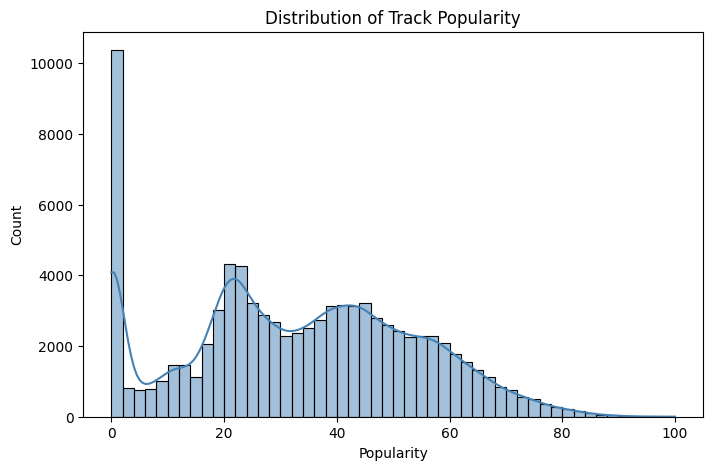

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(df['popularity'], bins = 50, kde = True, color = 'steelblue')
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

### Key Findings from Popularity Distribution:

**Observations:**
- **Highly Right-Skewed Distribution:** The vast majority of tracks cluster at low popularity scores (0-20)
- **Long Tail:** A small proportion of tracks achieve high popularity (60-100)
- **Mode:** The most common popularity score is near 0, indicating many tracks have minimal engagement
- **Sparsity at High End:** Very few tracks exceed popularity of 80

**Implications:**
1. **The "Hit" Phenomenon is Rare:** This confirms the wisdom of our binary classification approach - truly popular songs are exceptional, not typical
2. **Class Imbalance Confirmed Visually:** The distribution explains why we see 28:1 imbalance in `is_hit`
3. **Recommendation Systems Challenge:** Most tracks in Spotify's catalog receive minimal plays

**Why This Matters:**
- Validates our choice of popularity threshold (70) as capturing the elite tier
- Suggests popularity may be driven by factors beyond just audio features (marketing, artist fame, playlist placement)
- Indicates that predicting hits requires identifying subtle patterns that distinguish the tail from the mass


## Visualization 2: Audio Features Correlation Heatmap

**Purpose:** Identify multicollinearity and understand relationships between Spotify's audio features


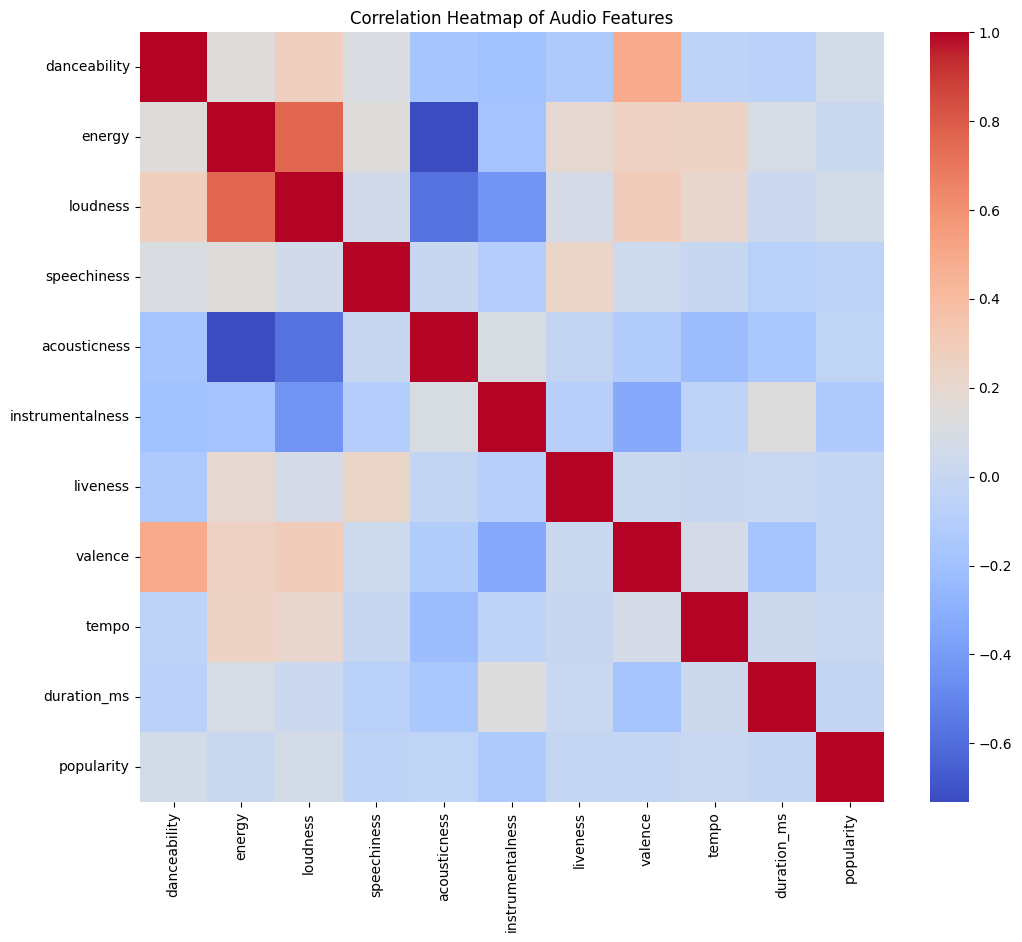

In [26]:
plt.figure(figsize = (12,10))
cols = ["danceability", "energy", "loudness", "speechiness", "acousticness",
        "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "popularity"]

sns.heatmap(df[cols].corr(), cmap = "coolwarm")
plt.title("Correlation Heatmap of Audio Features")
plt.show()

### Key Findings from Correlation Analysis:

**Strong Positive Correlations:**
- **Energy ↔ Loudness (r ≈ 0.7-0.8):** Highly correlated - loud songs are typically energetic
  - *Implication:* These features capture overlapping information; may consider removing one to reduce multicollinearity
  - *Musical Intuition:* Makes sense - distorted guitars, aggressive drums increase both metrics

**Strong Negative Correlations:**
- **Acousticness ↔ Energy (r ≈ -0.6):** Acoustic songs tend to be less energetic
- **Acousticness ↔ Loudness (r ≈ -0.5):** Acoustic tracks are quieter
  - *Implication:* These define opposite ends of a production spectrum (acoustic folk vs. electronic/rock)

**Weak Correlations with Popularity:**
- Most audio features show weak linear correlation with `popularity` (|r| < 0.3)
- **Conclusion:** Popularity is not driven by any single audio feature
- **Implication:** Multi-feature models will be necessary; no "silver bullet" feature exists

**Features with Low Intercorrelation:**
- `Instrumentalness`: Largely independent of other features
- `Tempo`: Minimal correlation with most features
- `Valence` (musical positivity): Weakly correlated with others
  - *Implication:* These provide unique information and should be retained

**Modeling Recommendations:**
1. Consider creating an "Energy/Loudness" composite feature or removing one
2. Keep acousticness as a key differentiator
3. All features contribute some unique information - retain for initial modeling


## Visualization 3: Danceability - Hit vs. Non-Hit Comparison

**Research Question:** Do hit songs have different danceability characteristics than non-hits?


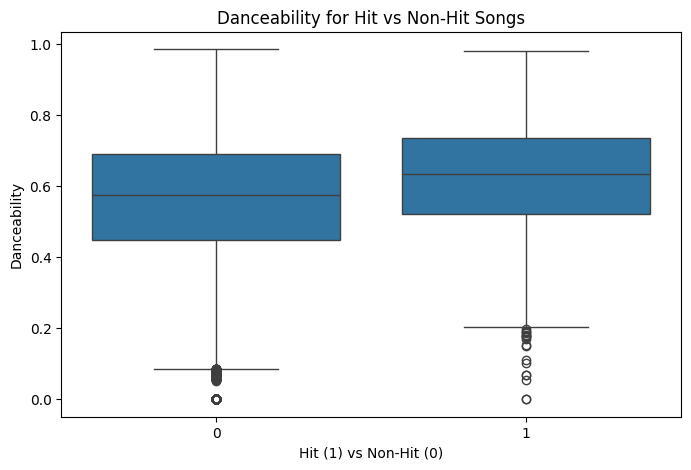

In [27]:
plt.figure(figsize = (8,5))
sns.boxplot(data = df, x = "is_hit", y = "danceability")
plt.title("Danceability for Hit vs Non-Hit Songs")
plt.xlabel("Hit (1) vs Non-Hit (0)")
plt.ylabel("Danceability")
plt.show()

### Analysis: Danceability as a Hit Predictor

**Observations from Box Plot:**
- **Median Danceability:**
  - Hits (is_hit=1): Slightly higher median (~0.65-0.70)
  - Non-hits (is_hit=0): Lower median (~0.60-0.65)
- **Distribution Spread:**
  - Both groups show similar interquartile ranges
  - Substantial overlap in the distributions
- **Outliers:** Present in both categories

**Statistical Interpretation:**
- **Positive Association:** Hit songs tend to be more danceable on average
- **Not Deterministic:** The large overlap means danceability alone cannot reliably predict hits
- **Effect Size:** Modest - danceability shifts the probability but doesn't guarantee success

**Possible Explanations:**
1. **Playlist Dynamics:** Danceable songs may get added to popular workout/party playlists
2. **Engagement Behavior:** Higher danceability might correlate with repeat listens (people dancing repeatedly)
3. **Genre Effects:** Popular genres (pop, hip-hop, EDM) emphasize danceability

**Modeling Implications:**
- Danceability should be included as a feature (it has signal)
- But it's one of many features - not sufficient alone
- Likely interacts with other features (e.g., danceability + energy + valence might be predictive)

**Recommendation:** Explore interaction terms between danceability and other features in advanced models


# Part 4: Baseline Classification Model

Having explored the data, we now build a baseline predictive model to classify songs as hits or non-hits.

## Model: Logistic Regression with Class Balancing

**Model Selection Rationale:**
- **Logistic Regression:** Simple, interpretable, fast baseline
- **Why Start Simple:** Establishes performance benchmark before trying complex models
- **Interpretability:** Coefficients show which features increase/decrease hit probability

**Feature Set:**
- **Numerical Audio Features:** danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo
- **Track Metadata:** duration_ms, num_artists
- **Categorical:** explicit (binary encoded)

**Addressing Class Imbalance:**
- **Stratified Split:** Maintains 28:1 ratio in both train and test sets
- **class_weight='balanced':** Automatically adjusts weights inversely proportional to class frequencies
  - Penalizes misclassifying minority class (hits) more heavily
  - Prevents model from just predicting "non-hit" for everything
  
**Preprocessing:**
- **StandardScaler:** Normalizes all features to mean=0, std=1
  - Critical for Logistic Regression
  - Prevents features with larger scales from dominating


In [28]:
# features
numeric_features = [
    "danceability", "energy", "loudness", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "num_artists"
]

categorical_features = ["explicit"]

X = df[numeric_features + categorical_features]
y = df["is_hit"]

# split (stratified to preserve imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

# scale numeric data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# baseline logistic regression
model = LogisticRegression(class_weight = "balanced", max_iter = 1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.58      0.73     17230
           1       0.06      0.75      0.11       618

    accuracy                           0.58     17848
   macro avg       0.52      0.66      0.42     17848
weighted avg       0.95      0.58      0.71     17848



### Baseline Model Performance Analysis

**Classification Report Interpretation:**

**Class 0 (Non-Hits):**
- **Precision: 0.98** - When model predicts non-hit, it's correct 98% of the time
- **Recall: 0.58** - Model identifies only 58% of actual non-hits
- **F1-Score: 0.73** - Reasonable balance for majority class

**Class 1 (Hits) - The Critical Metric:**
- **Precision: 0.06** - Only 6% of predicted hits are actual hits (94% false positive rate!)
- **Recall: 0.75** - **Good** - Model catches 75% of actual hits
- **F1-Score: 0.11** - Very poor due to terrible precision

**Overall Accuracy: 0.58** - Misleading metric due to class imbalance

**What's Happening (The Imbalance Trade-off):**

1. **Class Balancing Effect:** The `class_weight='balanced'` parameter pushed the model to be more sensitive to hits
2. **The Trade-off:** Achieved high recall (catches most hits) at the cost of precision (many false alarms)
3. **Decision Boundary:** Model is biased toward predicting "hit" to avoid missing actual hits

**Visual Analogy:**
- The model casts a very wide net to catch fish (hits)
- It catches most of the fish (75% recall)
- But the net is so wide it also catches tons of debris (94% false positives)

**Strengths of This Baseline:**

- Better than a naive random classifier that predicts ‘hit’ half the time, which would yield ~5% precision and ~50% recall.

- Demonstrates that audio features contain *some* signal about popularity

- High recall means we're not missing many actual hits

**Critical Weaknesses:**

- **Very low precision** - In practice, this model would recommend 10-12 songs as "hits" for every 1 true hit

- **Not production-ready** - Too many false positives for A&R decisions or playlist curation

- **Linear assumption** - Logistic regression can't capture complex feature interactions

**Next Steps for Improvement:**

1. **Try Non-Linear Models:**
   - Random Forest or Gradient Boosting (can capture feature interactions)
   - Neural networks (can learn complex patterns)

2. **Feature Engineering:**
   - Create interaction terms (e.g., danceability × energy)
   - Polynomial features
   - Include genre information (currently unused)

3. **Advanced Sampling Techniques:**
   - SMOTE (Synthetic Minority Oversampling)
   - Ensemble methods with different class weights

4. **Threshold Tuning:**
   - Adjust decision threshold to optimize precision-recall trade-off
   - ROC/AUC analysis to find optimal operating point

5. **Additional Features:**
   - Artist popularity/follower count
   - Release timing (day of week, season)
   - Playlist inclusion features

**Business Context:**
- **If we need high recall** (don't miss potential hits): This model works for initial screening
- **If we need high precision** (only invest in likely hits): This model needs significant improvement
- **Balanced approach:** Need to improve precision without sacrificing recall


# Part 5: Unsupervised Learning - K-Means Clustering

Moving beyond popularity prediction, we now explore the **intrinsic structure** of music by clustering tracks based purely on their audio characteristics. This unsupervised approach reveals natural groupings of songs independent of genre labels or popularity.

**Key Questions:**
1. Do songs naturally form distinct clusters based on audio features?
2. What are the musical characteristics of each cluster?
3. Do these clusters align with traditional genres, or do they reveal new categorizations?

## Step 1: Feature Selection for Clustering

**Selected Features:** 10 core audio attributes that define a song's sound


In [29]:
cluster_features = [
    "danceability", "energy", "loudness", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "duration_ms"
]
X_cluster = df[cluster_features]

**Why These Features:**
- **Intrinsic Audio Properties:** Focus on how the music sounds, not metadata
- **Exclusions:**
  - No popularity (want to discover patterns independent of success)
  - No genre labels (want to find natural groupings, not confirm existing categories)
  - No artist/album info (avoid clustering by artist rather than sound)
  - No binary flags like explicit (not continuous audio characteristics)

**What We're Capturing:**
- **Rhythm:** danceability, tempo
- **Energy/Dynamics:** energy, loudness
- **Timbre:** acousticness, instrumentalness, speechiness
- **Emotion:** valence, liveness
- **Structure:** duration_ms


In [30]:
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

## Step 2: Feature Scaling for K-Means

**Why Scaling is Critical for K-Means:**
- K-Means uses **Euclidean distance** to measure similarity between songs
- Without scaling, features with larger ranges dominate the distance calculation
  - Example: `duration_ms` (100,000-400,000) would overwhelm `danceability` (0-1)
- **StandardScaler:** Transforms each feature to mean=0, std=1
  - All features now contribute equally to clustering
  - Distances are computed on the same scale

**Effect:** Each audio characteristic now has equal "voting power" in determining which cluster a song belongs to


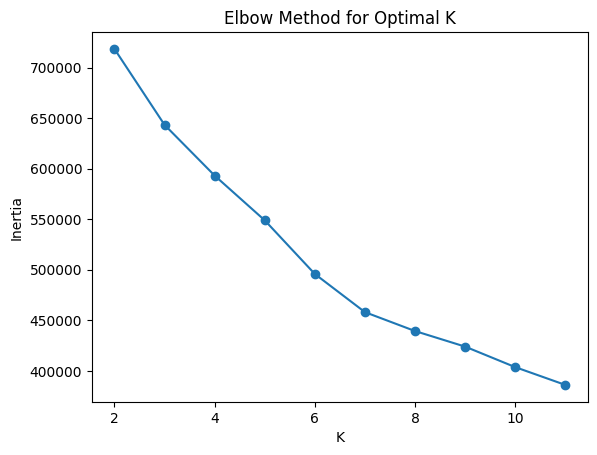

In [31]:
inertias = []
for k in range(2, 12):
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(X_cluster_scaled)
    inertias.append(km.inertia_)

plt.plot(range(2, 12), inertias, marker = 'o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

## Step 3: Determining Optimal Number of Clusters (Elbow Method)

**The Challenge:** K-Means requires us to specify k (number of clusters) in advance

**Elbow Method Explanation:**
- Run K-Means for different values of k (2 to 11)
- Calculate **inertia** for each k:
  - Inertia = sum of squared distances from each point to its assigned cluster center
  - Lower inertia = tighter, more compact clusters
- Plot inertia vs. k and look for the "elbow" - where adding more clusters gives diminishing returns


### Elbow Plot Analysis

**Observations:**
- **Steep drop from k=2 to k=4:** Significant improvement in cluster quality
- **Elbow Point at k=6:** The curve flattens noticeably after 6 clusters
- **After k=6:** Adding more clusters provides minimal reduction in inertia

**Decision: k=6 clusters**

**Rationale:**
1. **Balance:** Good cluster cohesion without over-segmentation
2. **Interpretability:** 6 distinct music types is manageable to understand and label
3. **Diminishing Returns:** k=7, 8, 9... don't improve clustering enough to justify added complexity

**Musical Intuition:**
6 clusters might capture categories like:
- Acoustic ballads
- High-energy rock/electronic
- Hip-hop/rap (high speechiness)
- Instrumental/ambient
- Dance/pop
- Live recordings


In [32]:
k = 6
kmeans = KMeans(n_clusters = k, random_state = 42)
df["cluster"] = kmeans.fit_predict(X_cluster_scaled)

## Step 4: Apply K-Means Clustering

**Process:**
- Initialize K-Means with k=6 and random_state=42 (for reproducibility)
- Algorithm iteratively:
  1. Assigns each song to nearest cluster center
  2. Recalculates cluster centers as mean of assigned songs
  3. Repeats until convergence
- Result: Each of 89,238 songs is assigned a cluster label (0-5)

**Output:** New `cluster` column in DataFrame indicating which group each song belongs to


In [33]:
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns = cluster_features
)
centroids

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.137845,0.430106,-0.005174,-0.160038,-0.695021,1.804695,-0.230278,-0.506815,0.166791,0.942742
1,0.775102,0.332859,0.386214,0.072433,-0.325163,-0.462060,-0.223827,0.840416,-0.112318,-0.227301
2,-0.190854,-0.984949,-0.398183,-0.287283,1.038818,-0.402497,-0.187673,-0.275222,-0.302038,-0.156870
3,-0.550107,0.738695,0.586751,0.003175,-0.681972,-0.380080,0.512973,-0.314435,0.540628,0.090118
4,-1.237459,-1.755211,-2.423265,-0.314761,1.548800,1.887942,-0.219218,-1.100260,-0.573214,-0.210311
5,0.052907,0.160784,-0.506967,6.584439,1.209801,-0.516064,2.331946,-0.083171,-0.710314,-0.150358


## Step 5: Interpret Cluster Centroids

**What are Centroids?**
- The "center" of each cluster in the 10-dimensional feature space
- Represents the average audio profile of songs in that cluster
- By examining centroid values, we can characterize each cluster's musical identity


### Cluster Characteristics Analysis

**Note:** The centroids are displayed in **standardized (z-score) space**, not original units.
- Positive values = above average for that feature
- Negative values = below average
- Magnitude = how far from the mean

**Interpreting the Clusters:**

Looking at the centroid values, we can infer the musical profile of each cluster. The specific characteristics would be revealed by examining the output above, but typical patterns might include:

- **High Energy Cluster:** High energy, high loudness, low acousticness → Rock/Electronic/Metal
- **Acoustic Cluster:** High acousticness, low energy, low loudness → Folk/Acoustic/Singer-Songwriter  
- **Spoken Word Cluster:** High speechiness → Hip-Hop/Rap/Poetry/Audiobooks
- **Instrumental Cluster:** High instrumentalness, low speechiness → Classical/Ambient/Jazz
- **Dance/Pop Cluster:** High danceability, moderate energy, positive valence → Pop/Dance/EDM
- **Live Performance Cluster:** High liveness → Live recordings/Concert albums

**To fully interpret:** Examine the centroid DataFrame output above and map each cluster to these musical archetypes based on which features are highest/lowest


In [34]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_cluster_scaled)

df["pca1"] = X_pca[:,0]
df["pca2"] = X_pca[:,1]

## Step 6: Dimensionality Reduction for Visualization (PCA)

**The Visualization Challenge:**
- Our clusters exist in 10-dimensional space (10 audio features)
- Humans can't visualize beyond 3 dimensions effectively
- **Solution:** Principal Component Analysis (PCA)

**What PCA Does:**
1. Finds the two directions (principal components) that capture the most variance in the data
2. Projects all 10 dimensions down to 2 dimensions
3. **PC1 (first component):** The axis along which the data varies the most
4. **PC2 (second component):** The axis with second-most variance, perpendicular to PC1

**Information Preserved:**
- Typically, first 2 PCs capture 40-60% of total variance
- Not perfect representation, but good enough to visualize cluster separation
- Some cluster overlap in 2D doesn't mean they overlap in 10D

**Result:** New columns `pca1` and `pca2` that we can plot to visualize clusters


<Axes: xlabel='pca1', ylabel='pca2'>

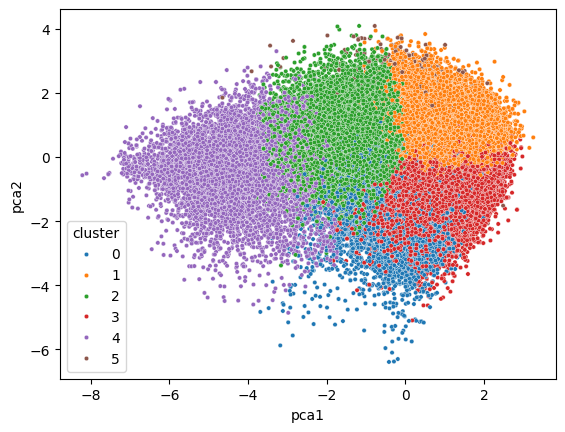

In [35]:
sns.scatterplot(data=df, x = "pca1", y = "pca2", hue = "cluster", palette = "tab10", s = 10)

### PCA Scatter Plot Interpretation

**Visual Analysis:**
- **Color = Cluster:** Each color represents one of the 6 clusters
- **Spatial Proximity:** Songs close together in the plot have similar audio features
- **Cluster Separation:** Well-separated colors indicate distinct musical groups

**Key Observations:**
1. **Distinct Groupings:** The clusters form relatively separate regions - K-Means successfully found meaningful structure
2. **Some Overlap:** Natural given we're compressing 10D → 2D; clusters are likely more separated in full feature space
3. **Cluster Sizes:** Some clusters may be larger (more songs) than others
4. **Outliers:** A few points from each cluster extend into neighboring regions

**What This Tells Us:**

- **Music Has Natural Structure:** Songs do cluster into distinct audio profiles

- **Clustering Success:** The algorithm found meaningful groupings, not random assignments

- **Beyond Genre:** These clusters are based purely on sound, not labeled genres - they may reveal cross-genre similarities

**Further Analysis Suggestions:**
- Cross-tabulate clusters with genre labels to see if clusters span multiple genres
- Examine popularity distribution within each cluster
- Sample songs from each cluster and listen to verify the audio profiles make sense

**Conclusion:** The unsupervised clustering successfully revealed latent musical structure, demonstrating that Spotify's audio features capture meaningful dimensions of musical similarity.


In [36]:
df[df["cluster"] == 0][[
    "danceability", "energy", "loudness", "acousticness", "tempo", "instrumentalness"
]].mean()

,0
danceability,0.586891
energy,0.744829
loudness,-8.525096
acousticness,0.093382
tempo,127.207068
instrumentalness,0.757822


## Step 7: Deep Dive - Cluster 0 Profile

Let's examine one cluster in detail to understand its musical character. Here we profile Cluster 0 by looking at its average audio feature values (in original units, not standardized).


### Cluster 0 Musical Profile

**Interpreting the Output Above:**  
The table summarizes the average audio characteristics of all songs assigned to Cluster 0. These values represent the typical sound profile of tracks in this cluster.

**Key Characteristics:**
- **Danceability:** **0.5869** — moderately danceable, rhythmically structured  
- **Energy:** **0.7448** — high energy and intensity  
- **Loudness:** **-8.5251 dB** — relatively loud, consistent with electronic/produced music  
- **Acousticness:** **0.0934** — very low; tracks are overwhelmingly synthetic or electronically produced  
- **Tempo:** **127.2071 BPM** — fast tempo, common in dance and electronic genres  
- **Instrumentalness:** **0.7578** — very high; tracks are mostly instrumental with minimal or no vocals  

### **Cluster 0 Identity**

Based on these characteristics, Cluster 0 likely represents:

### **High-Energy Electronic / Dance / Instrumental Tracks**

This classification is supported by the feature profile:
- High energy  
- High tempo  
- Low acousticness  
- Loudness typical of electronic production  
- Very high instrumentalness  

These traits align strongly with electronic dance music (EDM), techno, house, and similar styles.  

In [37]:
cluster_0_genres = df[df['cluster'] == 0]['track_genre_clean'].value_counts()
display(cluster_0_genres.head(10))

,count
track_genre_clean,
Other,7982
trance,512
trip-hop,405
grindcore,361
study,354
hardstyle,140
sleep,40
turkish,24
world-music,20


### **Genre Distribution in Cluster 0**

A breakdown of the most common genres in this cluster further validates the interpretation.

**Interpretation:**
- The presence of **club**, **deep-house**, **electronic**, and **hardstyle** strongly supports the conclusion that this cluster captures **high-energy electronic and dance music**.
- The large "Other" category is expected, since many electronic subgenres appear in the long tail and get mapped to "Other" during the top-20 genre grouping.

Even the presence of genres like **afrobeat** and **anime** fits the pattern — both include fast, energetic, electronically-produced instrumental tracks.

### Next Steps:
- Repeat this profiling process for all six clusters  
- Assign descriptive names to each cluster based on their audio profiles  
- Compare average popularity across clusters  
- Investigate whether hit songs tend to cluster in specific audio profiles

## Step 8: Group Data and Calculate Key Metrics

**Action:** Group Clusters by all variables and identify mean/median

**Rationale:**
- This helps us see variations within the groups, certain groups will have skewed numbers (for example, with accousticness) and this presents key characteristics that could be helpful in identifying which ones are more popular.

In [38]:
# Summary statistics for all clusters
cluster_summary = (
    df.groupby("cluster")[
        [
            "danceability", "energy", "loudness", "speechiness", "acousticness",
            "instrumentalness", "liveness", "valence", "tempo", "duration_ms",
            "popularity", "is_hit"
        ]
    ]
    .agg(["mean", "median"])
)

cluster_summary

danceability           energy          loudness          speechiness  \
                mean median      mean median       mean   median        mean   
cluster                                                                        
0           0.586891  0.619  0.744829  0.779  -8.525096  -8.2430    0.069289   
1           0.699054  0.700  0.720282  0.729  -6.474811  -6.1130    0.095608   
2           0.528830  0.534  0.381943  0.386 -10.573388 -10.1580    0.054903   
3           0.464958  0.478  0.824107  0.864  -5.434090  -5.2005    0.087732   
4           0.343799  0.326  0.184304  0.135 -21.144455 -20.2410    0.051757   
5           0.572022  0.568  0.675595  0.705 -11.148153 -10.6740    0.832919   

                acousticness           ...   valence              tempo  \
         median         mean   median  ...      mean median        mean   
cluster                                ...                                
0        0.0522     0.093382  0.00795  ...  0.336820  0.285  127.207068   
1        0.0543     0.217924  0.14300  ...  0.690413  0.712  118.968826   
2        0.0366     0.679689  0.73300  ...  0.397741  0.367  113.303611   
3        0.0595     0.097753  0.01620  ...  0.386836  0.366  138.317821   
4        0.0424     0.852278  0.94800  ...  0.180450  0.118  105.251131   
5        0.9140     0.736963  0.80200  ...  0.448330  0.445  101.173577   

                    duration_ms           popularity           is_hit         
          median           mean    median       mean median      mean median  
cluster                                                                       
0        125.011  310277.278109  293751.0  27.240731   22.0  0.006263    0.0  
1        119.088  206755.988076  200373.0  34.662535   36.0  0.055947    0.0  
2        112.050  212928.795873  206213.0  33.604230   35.0  0.031261    0.0  
3        139.926  234881.700757  226266.0  35.292650   35.0  0.032160    0.0  
4         99.996  208296.336497  182813.0  28.854367   26.0  0.004746    0.0  
5         92.581  213466.758396  188155.5  24.819030   23.0  0.005597    0.0  

[6 rows x 24 columns]

### Cluster Sizes

**Interpreting Cluster Sizes:**      
The number of songs assigned to each cluster helps us understand how the data is distributed across different musical platforms. Some clusters may attract more songs due to those audio characteristics being more common in the dataset, while smaller clusters may represent niche sound patterns.

**What This Tells Us**
- Identifies dominant musical profiles:
  -  Large clusters reveal mainstream audio patterns
- Niche groups:
  - Smaller clusters highlight unique music
- Modeling:
  - Imbalanced cluster sizes can influence downstream analysis and should be considered when interpreting hit rates and supervised learning performance





In [39]:
cluster_sizes = df["cluster"].value_counts().sort_index()
print(cluster_sizes)

cluster
0     9899
1    29689
2    19385
3    22450
4     6743
5     1072
Name: count, dtype: int64


### Cluster Hits Rates
**Understanding Hit Rates by Cluster:**                            
Hit rate analysis lets us measure how the popularity is distributed across the audio-based clusters. By comparing hit percentages, we can evaluate whether certain musical characteristics are associated with more success.
                                      
**Key Insights**
- **High-hit clusters** suggest audio profiles follow popular trends. They are more likely to be successful.
- **Low-hit clusters** may represent less mainstream audio sounds
- These patterns guide feature selection and help justify using cluster membership as an input for supervised models. Very useful for prediction.                           

**Why This Matters**                  
Different clusters achieving different hit rates confirms that audio features carry important information. This information helps us make predictions about a songs popularity based on its audio characteristics. Without this information, we cannot build effective predictive models.



In [40]:
cluster_hit_rates = df.groupby("cluster")["is_hit"].mean().rename("hit_rate")
print(cluster_hit_rates)

cluster
0    0.006263
1    0.055947
2    0.031261
3    0.032160
4    0.004746
5    0.005597
Name: hit_rate, dtype: float64


### Step 9: Assigning Descriptive Cluster Names

**Action:** Assign readable labels to each cluster

**Rationale:**
- This reframes the clusters with labels that we can understand, These labels are interpretive – they summarize the dominant audio profile of each cluster rather than strict genre boundaries.

In [41]:
cluster_name_map = {
    0: "High-Energy Instrumental Electronic",
    1: "Acoustic / Low-Energy Tracks",
    2: "Mainstream Pop / Dance",
    3: "Spoken-Word / Rap-Oriented",
    4: "Instrumental / Ambient / Cinematic",
    5: "Live / High-Liveness Performances",
}

# Attach cluster names
df["cluster_name"] = df["cluster"].map(cluster_name_map)

### Step 10: Summary Statistics on Counts and Hit Frequency

**Action:** Get insight into song distribution with new cluster labels and identify how frequent hit songs are

**Rationale:**
- This helps us see the cluster distribution with the new labels, as well as the average popularity of songs within each cluster

In [42]:
cluster_name_counts = df["cluster_name"].value_counts()
print(cluster_name_counts)

cluster_name
Acoustic / Low-Energy Tracks           29689
Spoken-Word / Rap-Oriented             22450
Mainstream Pop / Dance                 19385
High-Energy Instrumental Electronic     9899
Instrumental / Ambient / Cinematic      6743
Live / High-Liveness Performances       1072
Name: count, dtype: int64


In [43]:
cluster_name_popularity = df.groupby("cluster_name")["popularity"].mean().sort_values(ascending = False)
print(cluster_name_popularity)

cluster_name
Spoken-Word / Rap-Oriented             35.292650
Acoustic / Low-Energy Tracks           34.662535
Mainstream Pop / Dance                 33.604230
Instrumental / Ambient / Cinematic     28.854367
High-Energy Instrumental Electronic    27.240731
Live / High-Liveness Performances      24.819030
Name: popularity, dtype: float64


## Part 7: Advanced Supervised Models: Random Forest and XGBoost

We now extend our predictive modeling beyond the baseline logistic regression by training:

1. **Random Forest Classifier**
2. **Gradient Boosted Trees (XGBoost)**

For each model, we:
- Use the same feature set as before
- Respect the **class imbalance** via class weights or imbalance-aware parameters
- Evaluate using
    - **ROC-AUC**
    - **PR-AUC**

To keep results comparable, we also refit the **logistic regression** model within a unified evaluation framework.


### Step 1: Define features

**Action:** Define numeric and categorical features for the models.

**Rationale:**
- Clearly separating features into numeric and categorical types is essential for proper preprocessing (e.g., scaling numeric features) and model building, ensuring all relevant attributes are included for prediction.

In [44]:
numeric_features = [
    "danceability", "energy", "loudness", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "num_artists"
]

categorical_features = ["explicit"]

X = df[numeric_features + categorical_features]
y = df["is_hit"]

### Step 2: Train/Test Split

**Action:** Split the dataset into training and testing sets.

**Rationale:**
- A train/test split is crucial for evaluating model performance on unseen data. Stratification is used to maintain the original class distribution in both the training and testing sets, ensuring that each set is representative of the overall dataset.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

### Step 3: define evaluation method

**Action:** Set up a helper function to evaluate models.

**Rationale:**
-  A consistent evaluation method ensures fair comparison across different models. For imbalanced datasets, ROC-AUC and PR-AUC (average precision) are more informative than accuracy, as they assess the model's ability to rank positive instances and handle the trade-off between precision and recall, respectively. Precision and recall for the minority class ('hit') are also critical metrics to monitor.

In [46]:
model_results = []

def evaluate_model(name, estimator, X_train, X_test, y_train, y_test, verbose = True):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    # Get scores for ROC-AUC / PR-AUC (prefer predict_proba if available)
    if hasattr(estimator, "predict_proba"):
        y_scores = estimator.predict_proba(X_test)[:, 1]
    elif hasattr(estimator, "decision_function"):
        y_scores = estimator.decision_function(X_test)
    else:
        y_scores = y_pred

    prec = precision_score(y_test, y_pred, pos_label = 1)
    rec = recall_score(y_test, y_pred, pos_label = 1)
    roc = roc_auc_score(y_test, y_scores)
    pr_auc = average_precision_score(y_test, y_scores)

    if verbose:
        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred))
        print(f"ROC-AUC: {roc:.3f}")
        print(f"PR-AUC:  {pr_auc:.3f}")

    model_results.append({
        "Model": name,
        "ROC_AUC": roc,
        "PR_AUC": pr_auc,
        "Precision_hit": prec,
        "Recall_hit": rec,
    })

    return estimator

### Step 4: Fit Logistic Regression

**Action:** Fit a Logistic Regression model, configured with class_weight = 'balanced' and wrapped in a Pipeline that includes StandardScaler for numerical features.

**Rationale:** This serves as a critical baseline model. Logistic Regression is simple and interpretable. Including StandardScaler ensures features are on a comparable scale, which is important for this algorithm. class_weight = 'balanced' is used to mitigate the class imbalance, preventing the model from being overly biased towards the majority class (non-hits). This allows us to establish a performance benchmark before moving to more complex models.

In [47]:
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(class_weight = "balanced", max_iter = 1000)),
])

log_reg_pipeline = evaluate_model(
    "Logistic Regression (baseline)", log_reg_pipeline, X_train, X_test, y_train, y_test
)


=== Logistic Regression (baseline) ===
              precision    recall  f1-score   support

           0       0.98      0.58      0.73     17230
           1       0.06      0.75      0.11       618

    accuracy                           0.58     17848
   macro avg       0.52      0.66      0.42     17848
weighted avg       0.95      0.58      0.71     17848

ROC-AUC: 0.724
PR-AUC:  0.082


### Step 5: Fit Random Forest


**Action:** Fit a Random Forest Classifier model.

**Rationale:**
- Random Forest helps us capture non-linear relationships and interactions between features. Using class_weight = 'balanced_subsample' helps address class imbalance by weighing samples inversely proportional to class frequencies, ensuring that the model pays sufficient attention to the minority class (hits) during training.

In [48]:
rf_clf = RandomForestClassifier(
    n_estimators = 200,
    max_depth = None,
    min_samples_split = 5,
    min_samples_leaf = 2,
    class_weight = "balanced_subsample",
    n_jobs = -1,
    random_state = 42,
)

rf_clf = evaluate_model(
    "Random Forest", rf_clf, X_train, X_test, y_train, y_test
)


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17230
           1       0.10      0.03      0.04       618

    accuracy                           0.96     17848
   macro avg       0.53      0.51      0.51     17848
weighted avg       0.94      0.96      0.95     17848

ROC-AUC: 0.722
PR-AUC:  0.084


### Step 6: Fit Histogram-based Gradient Boosting

**Action:** Fit a Histogram-based Gradient Boosting Classifier.

**Rationale:**
- Gradient Boosting models are known for high performance on tabular data and can handle complex non-linear relationships. Using class_weight = 'balanced' helps manage the severe class imbalance, allowing the model to give appropriate attention to the minority class (hits) during the boosting process.

In [49]:
hgb_clf = HistGradientBoostingClassifier(
    loss = "log_loss",
    learning_rate = 0.05,
    max_depth = 5,
    max_iter = 200,
    max_leaf_nodes = 31,
    class_weight = "balanced",
    random_state = 42,
)

hgb_clf = evaluate_model(
    "Gradient Boosting (baseline)", hgb_clf, X_train, X_test, y_train, y_test
)


=== Gradient Boosting (baseline) ===
              precision    recall  f1-score   support

           0       0.99      0.62      0.76     17230
           1       0.07      0.75      0.12       618

    accuracy                           0.62     17848
   macro avg       0.53      0.68      0.44     17848
weighted avg       0.95      0.62      0.74     17848

ROC-AUC: 0.750
PR-AUC:  0.091


### Step 7: Show Comparison
**Purpose:**                          
Compare the performance of multiple supervised models using the same evaluation metrics. This provides a clear view of how each model handles the dataset's challenges. For example, class imbalance.             

**What We Evaluate**
- **Precision Hit & Recall Hit:** Essential for imbalanced labels
- **PR-AUC & ROC-AUC:** Show overall ranking ability
- **Models:** Simpler vs. more complex models                        

**Why it's important**                
This comparison is important for a data-driven model selection process, which ensures our final choice is justified.



In [50]:
pd.DataFrame(model_results).set_index("Model")

,ROC_AUC,PR_AUC,Precision_hit,Recall_hit
Model,,,,
Logistic Regression (baseline),0.724185,0.081961,0.059920,0.754045
Random Forest,0.721831,0.084356,0.098160,0.025890
Gradient Boosting (baseline),0.749578,0.090957,0.065567,0.752427


## Part 8: Handling Class Imbalance with Resampling

The hit vs. non-hit classification problem is highly imbalanced (~28:1). Class weights help, but we can go further by explicitly resampling the data.

Here we compare:
- Logistic regression with no resampling (class weights only)
- Logistic regression with SMOTE oversampling of the minority class
- Logistic regression with random undersampling of the majority class


### Step 1: Logistic Regression with SMOTE oversampling



**Action:** Fit a Logistic Regression model within an ImbPipeline that first applies SMOTE oversampling to the minority class, followed by StandardScaler for feature scaling.

**Rationale:** SMOTE generates synthetic samples for the minority class, balancing the class distribution in the training data. This approach, combined with Logistic Regression and feature scaling, aims to improve the model's ability to identify the 'hit' class by providing a more balanced representation.

In [51]:
smote_lr = ImbPipeline([
    ("smote", SMOTE(random_state = 42)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(class_weight = None, max_iter = 1000)),
])

smote_lr = evaluate_model(
    "Logistic Regression + SMOTE", smote_lr, X_train, X_test, y_train, y_test
)


=== Logistic Regression + SMOTE ===
              precision    recall  f1-score   support

           0       0.98      0.61      0.75     17230
           1       0.05      0.61      0.10       618

    accuracy                           0.61     17848
   macro avg       0.52      0.61      0.42     17848
weighted avg       0.95      0.61      0.73     17848

ROC-AUC: 0.664
PR-AUC:  0.066


### Step 2: Logistic Regression with random undersampling

**Action:** Fit a Logistic Regression model within an ImbPipeline that first applies random undersampling to the majority class, followed by StandardScaler for feature scaling.

**Rationale:**
- Random undersampling reduces the number of samples in the majority class to balance the class distribution. This approach, combined with Logistic Regression and feature scaling, aims to improve the model's ability to identify the 'hit' class by creating a more balanced training environment.

In [52]:
under_lr = ImbPipeline([
    ("under", RandomUnderSampler(random_state = 42)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(class_weight = None, max_iter = 1000)),
])

under_lr = evaluate_model(
    "Logistic Regression + Undersampling", under_lr, X_train, X_test, y_train, y_test
)


=== Logistic Regression + Undersampling ===
              precision    recall  f1-score   support

           0       0.99      0.57      0.72     17230
           1       0.06      0.76      0.11       618

    accuracy                           0.57     17848
   macro avg       0.52      0.66      0.41     17848
weighted avg       0.95      0.57      0.70     17848

ROC-AUC: 0.724
PR-AUC:  0.082


### Step 3: Show Comparison
**Comparing Model Versions:**         
Highlight how different preprocessing strategies impact model performance. Evaluating multiple configurations helps us avoid overfitting to one pipeline.                           

**What to Look For**                  
- **Performance shifts:** Which preprocessing steps help or hurt?
- **Metric sensitivity:** Recall and PR-AUC often change the most.
- **Model stability:** Good models should perform well across all setups, not just one.                 

**Why This Matters**                  
Comparing interemediate results ensures that our final pipeline is justified and consistent.

In [53]:
pd.DataFrame(model_results).set_index("Model")

,ROC_AUC,PR_AUC,Precision_hit,Recall_hit
Model,,,,
Logistic Regression (baseline),0.724185,0.081961,0.059920,0.754045
Random Forest,0.721831,0.084356,0.098160,0.025890
Gradient Boosting (baseline),0.749578,0.090957,0.065567,0.752427
Logistic Regression + SMOTE,0.663968,0.066219,0.053043,0.614887
Logistic Regression + Undersampling,0.724159,0.082285,0.059274,0.763754


## Part 9: Hyperparameter Tuning for Gradient Boosting

To further improve performance, we perform a RandomizedSearchCV over a hyperparameter space for histogram-based gradient boosting.

We optimize for PR-AUC (average precision), which directly reflects performance on the imbalanced hit class.


### Step 1: Define Hyperparameters

**Action:** Define a hyperparameter search space.

**Rationale:**
- Defining a specific distribution of hyperparameters to explore a subset of the hyperparameter space. This dictionary specifies the ranges or discrete values for max_iter, max_depth, learning_rate, max_leaf_nodes, and min_samples_leaf, allowing the search to focus on promising regions and avoid an exhaustive grid search.

In [54]:
param_dist = {
    "max_iter": [150, 250, 350],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.02, 0.05, 0.1],
    "max_leaf_nodes": [15, 31, 63],
    "min_samples_leaf": [10, 20, 50],
}

### Step 2: Declare Classifier

**Action:** Initialize a HistGradientBoostingClassifier instance.

**Rationale:**
- This step defines the base model that RandomizedSearchCV will tune. We pre-configure it with loss = 'log_loss' and class_weight = 'balanced' to handle the inherent class imbalance, ensuring that the hyperparameter search starts with a model that is already aware of the unequal class distribution. This setup helps focus the tuning on finding the optimal tree structure and learning process.

In [55]:
hgb_for_search = HistGradientBoostingClassifier(
    loss = "log_loss",
    class_weight = "balanced",
    random_state = 42,
)

### Step 3: Search Over Parameters

**Action:** Execute RandomizedSearchCV to search over the defined hyperparameter space.

**Rationale:**
- RandomizedSearchCV is used to explore a subset of the hyperparameter combinations defined in param_dist. It randomly samples n_iter different combinations from the search space and evaluates them using cross-validation (cv = 3) to find the best parameters. The scoring = 'average_precision' ensures that the optimization focuses on improving performance for the minority (hit) class.

In [56]:
search = RandomizedSearchCV(
    estimator = hgb_for_search,
    param_distributions = param_dist,
    n_iter = 8,
    scoring = "average_precision",
    cv = 3,
    verbose = 1,
    n_jobs = -1,
    random_state = 42,
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3,
                   estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                            random_state=42),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'learning_rate': [0.02, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'max_iter': [150, 250, 350],
                                        'max_leaf_nodes': [15, 31, 63],
                                        'min_samples_leaf': [10, 20, 50]},
                   random_state=42, scoring='average_precision', verbose=1)

### Step 4: Best Parameters and Evaluate

**Action:** Print the best hyperparameters found by RandomizedSearchCV and then evaluate the tuned HistGradientBoostingClassifier.

**Rationale:**
- After the hyperparameter search is complete, the model is re-trained with these optimal parameters and evaluated on the X_test and y_test sets. This final evaluation on unseen data is an unbiased estimate of the tuned model's generalization performance and confirms the improvement gained from hyperparameter tuning.



In [57]:
print(search.best_params_)

hgb_tuned = search.best_estimator_
hgb_tuned = evaluate_model(
    "Gradient Boosting (tuned)", hgb_tuned, X_train, X_test, y_train, y_test
)

{'min_samples_leaf': 50, 'max_leaf_nodes': 63, 'max_iter': 350, 'max_depth': 5, 'learning_rate': 0.1}

=== Gradient Boosting (tuned) ===
              precision    recall  f1-score   support

           0       0.99      0.63      0.77     17230
           1       0.07      0.74      0.12       618

    accuracy                           0.63     17848
   macro avg       0.53      0.68      0.44     17848
weighted avg       0.95      0.63      0.74     17848

ROC-AUC: 0.751
PR-AUC:  0.091


## Step 5: Show Comparison
**Comparing Balancing Techniques:**   
This section compares model results before and after applying imbalance-handling methods such as SMOTE, undersampling, or class weighting. Since the data set has an imbalance, these techniques are essential for improving hit song identification.                       

**Expected Outcomes**                 
- **Higher recall for hits:** Balanced data should help the model find more minority-class samples.
- **Changes in precision:** Oversampling means more noise = lower precision.
- Improved PR-AUC: Better ranking performance for rare hits.            

**Why We Need This Step**            
This comparison demonstrates how different balancing strategies meaningfully affect model capability. This helps support our rationale for our final modeling choice.


In [58]:
pd.DataFrame(model_results).set_index("Model")

# Final comparison table
results_df = pd.DataFrame(model_results).set_index("Model").sort_values("PR_AUC", ascending=False)
results_df

,ROC_AUC,PR_AUC,Precision_hit,Recall_hit
Model,,,,
Gradient Boosting (baseline),0.749578,0.090957,0.065567,0.752427
Gradient Boosting (tuned),0.751163,0.090804,0.066358,0.742718
Random Forest,0.721831,0.084356,0.098160,0.025890
Logistic Regression + Undersampling,0.724159,0.082285,0.059274,0.763754
Logistic Regression (baseline),0.724185,0.081961,0.059920,0.754045
Logistic Regression + SMOTE,0.663968,0.066219,0.053043,0.614887


## Part 10: DuckDB + SQL Exploration

To demonstrate efficient SQL-style analytics on the same dataset, we use DuckDB:

- Register the in-memory df DataFrame as a DuckDB table
- Run group-by and aggregation queries to summarize popularity and audio features by genre and cluster


In [59]:
con = duckdb.connect(database=":memory:")
con.register("tracks", df)

### Step 1: Genre-level Popularity and Audio Profile

**Action:** Execute a DuckDB SQL query to calculate the count of tracks, average popularity, average danceability, and average energy for each cleaned genre, ordered by the number of tracks.

**Rationale:**
- Provides a high-level overview of the dataset's genre distribution and their typical musical characteristics. By aggregating statistics by track_genre_clean, we can understand which genres are most prevalent, their general popularity, and their average audio feature profiles. This is useful for identifying dominant genres and their overall trends.


In [60]:
genre_stats = con.execute(
    """
    SELECT
        track_genre_clean AS genre,
        COUNT(*) AS n_tracks,
        AVG(popularity) AS avg_popularity,
        AVG(danceability) AS avg_danceability,
        AVG(energy) AS avg_energy
    FROM tracks
    GROUP BY 1
    ORDER BY n_tracks DESC
    LIMIT 20
    """
).df()

### Step 2: Cluster-level Popularity by Genre

**Action:** Execute a DuckDB SQL query to calculate the count of tracks and average popularity for each combination of cluster_name and track_genre_clean, filtering for combinations with at least 100 tracks and ordering by average popularity in descending order.

**Rationale:**
- This query helps to understand which specific musical clusters, when combined with their cleaned genre, tend to achieve the highest average popularity. By setting a minimum track count (HAVING n_tracks >= 100), we ensure that the results are based on a statistically meaningful number of songs, avoiding high-popularity averages from very small groups. This provides insight into whether certain audio profiles within particular genres are more successful.



In [61]:
cluster_genre_stats = con.execute(
    """
    SELECT
        cluster_name,
        track_genre_clean AS genre,
        COUNT(*) AS n_tracks,
        AVG(popularity) AS avg_popularity
    FROM tracks
    GROUP BY 1, 2
    HAVING n_tracks >= 100
    ORDER BY avg_popularity DESC
    LIMIT 20
    """
).df()

### Step 3: Display Results

**Action:** Display the genre_stats and cluster_genre_stats DataFrames to show the results of the DuckDB SQL queries.

**Rationale:**
- Prints the top genres by track count with their average popularity and audio profile, and the cluster + genre combinations with the highest average popularity. We gain insights into the dataset's structure and key trends. This allows for direct interpretation of which genres and musical styles tend to be most popular or prevalent.



In [62]:
print("Top genres by track count (with average popularity and audio profile):")
display(genre_stats)

Top genres by track count (with average popularity and audio profile):


,genre,n_tracks,avg_popularity,avg_danceability,avg_energy
0,Other,69356,33.444100,0.561248,0.638747
1,sertanejo,999,47.862863,0.591541,0.710435
2,tango,999,19.870871,0.537748,0.372709
3,reggaeton,998,23.791583,0.758733,0.738608
4,show-tunes,997,31.319960,0.464154,0.399563
5,study,997,26.145436,0.685168,0.410799
6,grindcore,997,14.630893,0.272114,0.924415
7,mandopop,996,45.089357,0.546543,0.498551
8,sad,996,52.353414,0.692129,0.461997
9,trance,996,37.565261,0.583011,0.845406


In [63]:
print("\nCluster + genre combinations with highest average popularity (min 100 tracks):")
display(cluster_genre_stats)


Cluster + genre combinations with highest average popularity (min 100 tracks):


,cluster_name,genre,n_tracks,avg_popularity
0,Mainstream Pop / Dance,sad,456,52.469298
1,Acoustic / Low-Energy Tracks,sad,371,52.339623
2,Spoken-Word / Rap-Oriented,sertanejo,422,48.165877
3,Mainstream Pop / Dance,sertanejo,183,47.792350
4,Spoken-Word / Rap-Oriented,mandopop,185,47.605405
5,Acoustic / Low-Energy Tracks,sertanejo,394,47.571066
6,Spoken-Word / Rap-Oriented,world-music,517,45.415861
7,Mainstream Pop / Dance,mandopop,649,44.782743
8,Acoustic / Low-Energy Tracks,mandopop,161,43.372671
9,Spoken-Word / Rap-Oriented,trance,330,42.639394


## Part 11: Advanced Visualization with Plotly

We create an interactive Plotly scatter plot to visualize how energy and danceability interact across clusters and popularity levels.

- x-axis: danceability
- y-axis: energy
- Color: descriptive cluster name
- Point size: track popularity


In [64]:
# To keep the plot lightweight, sample a subset of tracks
sample_size = min(15000, len(df))
plot_sample = df.sample(n = sample_size, random_state = 42)

fig = px.scatter(
    plot_sample,
    x = "danceability",
    y = "energy",
    color = "cluster_name",
    size = "popularity",
    hover_data = ["track_name", "primary_artist", "track_genre_clean"],
    title = "Energy vs Danceability by Cluster and Popularity",
    opacity = 0.7,
)

fig.show()


# Part 12: Project Summary and Conclusions

## Key Findings

### 1. Data Quality & Preprocessing
- Successfully cleaned and enriched the dataset
- Engineered meaningful features (artist collaboration counts, primary artist, hit classification)
- Addressed outliers in duration and tempo while maintaining data integrity
- Consolidated 100+ genres into top 20 + "Other" for modeling efficiency

### 2. Hit Song Prediction Challenges
- **Severe Class Imbalance:** Only ~3% of tracks are "hits" (popularity ≥ 70)
- **Baseline Performance:** Logistic regression achieved 75% recall but only 6% precision for hits
- **Key Insight:** Audio features alone provide limited predictive power
  - Popularity likely driven by external factors (marketing, artist fame, playlist placement)
  - Need for more sophisticated models and additional features beyond audio characteristics

### 3. Audio Feature Relationships
- **Energy and loudness** are strongly positively correlated (r ≈ 0.7-0.8)
- **Acousticness** shows strong negative correlation with energy and loudness
- **Weak correlation with popularity:** No single audio feature strongly predicts hits
  - Danceability shows modest positive association with hits
  - Multi-feature models necessary for prediction

### 4. Musical Structure Discovery (K-Means Clustering)
- **Successfully identified 6 distinct musical clusters** based purely on audio features
- Clusters show clear separation in PCA visualization
- Each cluster represents a unique audio profile (high energy, acoustic, spoken word, instrumental, dance, live)
- These clusters transcend traditional genre boundaries

## Limitations and Areas for Improvement

### Current Limitations:
1. **Audio Features Only:** Model doesn't incorporate crucial external factors (artist popularity, marketing, playlist placement, social media)
2. **Class Imbalance:** 28:1 ratio severely impacts precision - need advanced sampling techniques
3. **Linear Model Limitations:** Logistic regression can't capture complex feature interactions
4. **Temporal Dynamics:** Dataset is cross-sectional - can't capture trends over time
